In [215]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import figure
from pathlib import Path
import scipy
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor 

In [216]:
write_complete_dataframe_path = Path("__file__").parent.joinpath("Manipulated_Data", "Merged_Data").parent.joinpath("Merged_Data", "Merged-Data.csv")
df= pd.read_csv(write_complete_dataframe_path, index_col=0)
df.head()

,Date,Carbon Price,Coal Price,Oil Price,NatGas Price,Weighted Temp,Cold Temp,Hot Temp,Phase two,Phase three
0,2012-11-09,8.20,87.95,108.61,27.20,39.424568,0.0,0.0,0,0
1,2012-11-13,8.49,88.40,108.82,27.32,40.082543,0.0,0.0,0,0
2,2012-11-16,6.75,89.55,106.81,27.60,38.062586,0.0,0.0,0,0
3,2012-11-20,6.47,89.15,110.01,27.53,40.055418,0.0,0.0,0,0
4,2012-11-23,6.75,89.35,110.14,27.80,39.543410,0.0,0.0,0,0


In [217]:
df = df[df["Date"] >= "2019-01-01"]
df = df[df["Date"] <= "2022-12-31"]

In [218]:
#y = df["Carbon Price"]
#X = df[["Coal Price", "Oil Price",  "NatGas Price" ,"Cold Temp", "Hot Temp"]]

In [219]:
#df["Returns"] = df["Carbon Price"].pct_change()
df["target"] = df["Carbon Price"].shift(-1)
df.dropna(inplace=True)
#df2 = df[["Carbon Price"]]
df = df[["Carbon Price", "target"]]

df.head()

,Carbon Price,target
1112,23.01,22.40
1113,22.40,21.40
1114,21.40,21.95
1115,21.95,22.55
1116,22.55,22.81


In [220]:
def train_test_split(data, perc):
    data = data.values
    n = int(len(data)*(1-perc))
    return data[:n], data[n:]

In [221]:
train, test = train_test_split(df, 0.2)

In [222]:
print(len(test))

127


In [223]:
X = train[:,:-1]
y = train[:, -1]

In [224]:
from xgboost import XGBRegressor


In [225]:
model = XGBRegressor(objective="reg:squarederror", n_estimators = 1000)
model.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [226]:
test[0]

array([54.17, 55.  ])

In [227]:
val = np.array(test[1,0]).reshape(1,-1)
pred = model.predict(val)
print(pred[0])

55.39261


In [228]:
def xgb_predict(train, val):
    train = np.array(train)
    X,y = train[:,:-1], train[:, -1]
    model = XGBRegressor(objective="reg:squarederror", n_estimators = 1000)
    model.fit(X,y)
    
    val = np.array(val).reshape(1,-1)
    pred = model.predict(val)
    return pred[0]

In [229]:
xgb_predict(train, test[0,0])

55.567352

#### Walk-forward validation

Since we are making a one step forward prediction in this case, a daily prediction, we will predict the first record in the test dataset. Afterwards, we add the
real observation from the test set to the train set, refit the model, then predict the next step in the test dataset.

In [230]:
def validate(data, perc):
    predictions = []
    train, test = train_test_split(data, perc)
    history = [x for x in train]

    for i in range(len(test)):
        test_X, test_y = test[i,:-1], test[i, -1]
        pred = xgb_predict(history, test_X[0])
        predictions.append(pred)
        history.append(test[i])

    error = mean_squared_error(test[:, -1], predictions, squared=False)
    return error, test[:,-1], predictions

In [231]:
rmse, test, pred = validate(df, 0.25)


In [232]:
# Evaluate the performance of the model
print('mean_squared_error : ', mean_squared_error(test, pred))
print('mean_absolute_error : ', mean_absolute_error(test, pred))
print("root_mean_squared_error: ", np.sqrt(mean_squared_error(test,pred)))
print("R^2: " ,r2_score(test, pred))
print("Adjusted R^2: " , 1 - ( 1-r2_score(test, pred) ) * ( len(pred) - 1 ) / ( len(pred) - X.shape[1] - 1 ))

mean_squared_error :  7.452704813044889
mean_absolute_error :  1.9601196768898632
root_mean_squared_error:  2.7299642512393616
R^2:  0.9562514316354479
Adjusted R^2:  0.9559727783337628


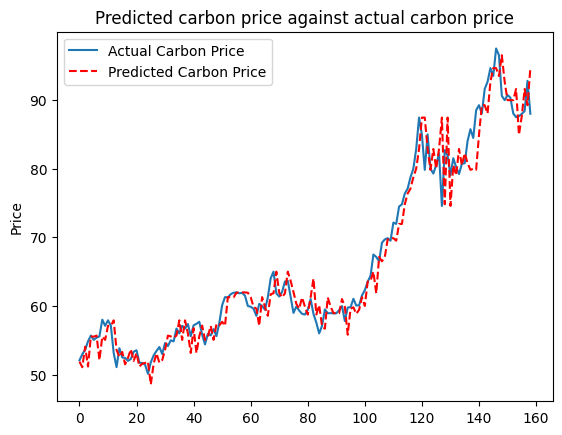

In [233]:
plt.plot(test, label = 'Actual Carbon Price')
plt.plot(pred, label ='Predicted Carbon Price', color = "red", linestyle = '--')
plt.legend()
plt.title("Predicted carbon price against actual carbon price")
plt.ylabel("Price")
plt.savefig("Model.png")
plt.show() 

In [234]:
# Evaluate the performance of the model
print('mean_squared_error : ', mean_squared_error(test, pred))
print('mean_absolute_error : ', mean_absolute_error(test, pred))
print("root_mean_squared_error: ", np.sqrt(mean_squared_error(test,pred)))
print("R^2: " ,r2_score(test, pred))


mean_squared_error :  7.452704813044889
mean_absolute_error :  1.9601196768898632
root_mean_squared_error:  2.7299642512393616
R^2:  0.9562514316354479


In [235]:
index = y_test.index
predictions = pd.DataFrame(predictions)
predictions["Index"] = index
predictions.set_index("Index", inplace = True)
predictions.rename(columns={0: "Carbon Price"}, inplace=True)
predictions.sort_index(inplace=True)

NameError: name 'y_test' is not defined

In [ ]:
predictions

In [ ]:
plt.plot(y_test, label = 'Actual Carbon Price')
plt.plot(predictions, label ='Predicted Carbon Price')
plt.title("Predicted carbon price against actual carbon price")
plt.ylabel("Price")
plt.legend()
plt.savefig("FullModel.png")
plt.show() 